# **Disentangled Representational Learning of Single Lead Electrocardiogram Signals using Variational Autoencoder**

This notebook evaluates the properties and accuracy of the trained VECG model in several aspects. The structure follows the three main objectives:

1. investigation of **Disentanglement**
2. evaluation of **Anomaly Detection** accuracy and explainability
3. improvements through the use of **Personalization**

The results are summarized in a corresponding article, which the authors ask to be cited when using the results of this work.

## General

This section of for imports, getting an overview of all experiments, and loading the most suitable model.

In [1]:
import sys
import os
import warnings
import logging
from absl import logging as absl_logging

# ✅ Ensure Correct TensorFlow Configuration
os.environ['TFDS_DATA_DIR'] = r"/data/newc6477/VAE/Mean_Beat/All_Physionet/"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# ✅ Ensure Correct Working Directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print(f"📂 Project Root: {PROJECT_ROOT}")

# ✅ Ensure `src/` is in Python's Path
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

print(f"✅ Updated sys.path:\n{sys.path}")

# ✅ Suppress Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
absl_logging.set_verbosity(absl_logging.ERROR)

# ✅ Import Modules
try:
    from src.utils.helper import Helper
    from src.evaluate.visualizations import Visualizations
    print("✅ Successfully imported `Helper` and `Visualizations`")
except ModuleNotFoundError as e:
    print(f"❌ Import Error: {e}")
    print("🔍 Check if `src/` has `__init__.py` and is in `sys.path`.")

# ✅ Import Other Required Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
from neurokit2.signal import signal_smooth

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import ipywidgets as widgets
from matplotlib import pyplot as plt
import seaborn as sns
import json



📂 Project Root: /users/newc6477/VAE/12_Lead_VECG
✅ Updated sys.path:
['/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python310.zip', '/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python3.10', '/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python3.10/lib-dynload', '', '/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python3.10/site-packages', '/users/newc6477/VAE/12_Lead_VECG', '/users/newc6477/VAE/12_Lead_VECG/src']


2025-04-05 15:56:01.198416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 15:56:01.198492: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 15:56:01.198550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 15:56:09.258151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


✅ Successfully imported `Helper` and `Visualizations`


In [2]:
# The resolution for saving images
DPI = 300

# The source path of the experiments and models
PATH = r"/users/newc6477/VAE/12_Lead_VECG/results/run_10s"

# Some operations take some time in computation.
# Therefore, the stored intermediate results can be used to skip the respective computation.
USE_PRECOMPUTED = True

## physionet

### Data Preparation

The consecutive steps are:

1. Loading the physionet train, validation, and test data set
2. Embedding the data sets
3. Excluding the non-relevant pathologies, i.e., LAE, ICB, FAC
4. Preparing the matrix and their associated binary and multiclass labels

In [4]:
# Path to your model base directory
BASE = '/users/newc6477/VAE/12_Lead_VECG/results/mean_all/test_is_split1'

# Path to the JSON file containing best timestamps for each lead
json_path = "best_folders.json"

# Load best folder names from JSON
with open(json_path, "r") as f:
    best_folders = json.load(f)

# Load models dynamically into a dictionary
models = {}
for lead_key, folder in best_folders.items():
    # Strip "lead_" prefix → "lead_I" → "I"
    lead = lead_key.replace("lead_", "")
    
    model_path = os.path.join(BASE, lead, folder, "model_best.keras")
    if os.path.exists(model_path):
        print(f"✅ Loading model for {lead} from {model_path}")
        models[lead] = tf.keras.models.load_model(model_path, compile=False)
    else:
        print(f"❌ Warning: Model not found for {lead} at {model_path}")


# If needed, convert to a list
model_list = list(models.values())

✅ Loading model for I from /users/newc6477/VAE/12_Lead_VECG/results/mean_all/test_is_split1/I/2025-04-05_06-03-31/model_best.keras
✅ Loading model for II from /users/newc6477/VAE/12_Lead_VECG/results/mean_all/test_is_split1/II/2025-04-05_06-59-44/model_best.keras
✅ Loading model for III from /users/newc6477/VAE/12_Lead_VECG/results/mean_all/test_is_split1/III/2025-04-05_09-07-25/model_best.keras
✅ Loading model for aVR from /users/newc6477/VAE/12_Lead_VECG/results/mean_all/test_is_split1/aVR/2025-04-05_10-36-07/model_best.keras
✅ Loading model for aVF from /users/newc6477/VAE/12_Lead_VECG/results/mean_all/test_is_split1/aVF/2025-04-04_19-04-23/model_best.keras
✅ Loading model for V1 from /users/newc6477/VAE/12_Lead_VECG/results/mean_all/test_is_split1/V1/2025-04-04_22-07-36/model_best.keras
✅ Loading model for V2 from /users/newc6477/VAE/12_Lead_VECG/results/mean_all/test_is_split1/V2/2025-04-04_23-51-26/model_best.keras
✅ Loading model for V3 from /users/newc6477/VAE/12_Lead_VECG/resu

In [5]:
train_splits = ['split2', 'split3', 'split4', 'split5']
dataset_config = {
    'name': ['physionet'],
    'split': train_splits,
    'shuffle_size': 1024,
    'batch_size': 1024,
}
test_splits = ['split1']
dataset_test = {
    'name': ['physionet'],
    'split': test_splits,
    'shuffle_size': 1024,
    'batch_size': 1024,
}

In [6]:
df_physionet_train, ld = Helper.get_embeddings(model_list, dataset_config)
#df_physionet_validation, _ = Helper.get_embeddings(model, dataset_physionet_validation)
df_physionet_test, _ = Helper.get_embeddings(model_list, dataset_test)

df_physionet_train = df_physionet_train[0]
#df_physionet_validation = df_physionet_validation[0]
df_physionet_test = df_physionet_test[0]
print(type(df_physionet_train))



📦 Loading dataset: physionet
  ⤷ Using splits: ['split2', 'split3', 'split4', 'split5']
🔍 Processing lead I...
     66/Unknown - 2s 29ms/step✅ Generator exhausted normally.
69/69 [==============================] - 2s 29ms/step
🔍 Processing lead II...
     68/Unknown - 2s 28ms/step✅ Generator exhausted normally.
69/69 [==============================] - 2s 28ms/step
🔍 Processing lead III...
     68/Unknown - 2s 28ms/step✅ Generator exhausted normally.
69/69 [==============================] - 2s 28ms/step
🔍 Processing lead aVR...
     67/Unknown - 2s 30ms/step✅ Generator exhausted normally.
69/69 [==============================] - 2s 30ms/step
🔍 Processing lead aVL...
     68/Unknown - 2s 28ms/step✅ Generator exhausted normally.
69/69 [==============================] - 2s 28ms/step
🔍 Processing lead aVF...
     68/Unknown - 2s 27ms/step✅ Generator exhausted normally.
69/69 [==============================] - 2s 28ms/step
🔍 Processing lead V1...
     68/Unknown - 2s 28ms/step✅ Generator ex

In [7]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Prepare feature matrix and labels
X_train = df_physionet_train.iloc[:, :ld].values  
X_test = df_physionet_test.iloc[:, :ld].values  
y_train = np.array(df_physionet_train['diagnostic'].tolist(), dtype=int)  
y_test = np.array(df_physionet_test['diagnostic'].tolist(), dtype=int)  

# Define KNN model
knn = KNeighborsClassifier()

# Wrap it inside MultiOutputClassifier
multi_label_knn = MultiOutputClassifier(knn, n_jobs=-1)

# Define Grid Search parameters for 'k'
param_grid = {
    "estimator__n_neighbors": [3, 5, 7, 9, 11]  # Testing different values of k
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    multi_label_knn, param_grid, scoring="accuracy", cv=5, n_jobs=-1
)

# Perform the Grid Search
print("🔍 Performing Grid Search...")
grid_search.fit(X_train, y_train)

# Best hyperparameter
print("✅ Best k found:", grid_search.best_params_)

# Use the best model
best_knn = grid_search.best_estimator_

# Predict using the best model
y_pred = best_knn.predict(X_test)



🔍 Performing Grid Search...


✅ Best k found: {'estimator__n_neighbors': 9}


In [8]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Calculate accuracy for each label separately
accuracy_per_label = (y_pred == y_test).mean(axis=0)

# Calculate overall accuracy (percentage of completely correct multi-label predictions)
overall_accuracy = accuracy_score(y_test, y_pred)

# Compute F1-score (macro & micro average)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(y_test.shape[1])])

# Print evaluation metrics
print("✅ Overall Accuracy:", overall_accuracy)
print("✅ F1 Score (Macro):", f1_macro)
print("✅ F1 Score (Micro):", f1_micro)
print("✅ Classification Report:\n", class_report)

✅ Overall Accuracy: 0.41342776203966003
✅ F1 Score (Macro): 0.2640622971364346
✅ F1 Score (Micro): 0.5536824683768767
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.22      0.29      1087
           1       0.55      0.57      0.56      1641
           2       0.62      0.05      0.09       106
           3       0.00      0.00      0.00        49
           4       0.90      0.54      0.68       323
           5       0.88      0.73      0.80       974
           6       0.78      0.08      0.14       715
           7       1.00      0.01      0.03       356
           8       0.64      0.34      0.44      1528
           9       0.63      0.31      0.41       459
          10       0.00      0.00      0.00        91
          11       0.67      0.01      0.01       336
          12       0.50      0.00      0.01       346
          13       0.50      0.01      0.01       334
          14       0.72      0.68      0.70  

🚀 Starting training...


Epochs:   7%|▋         | 1/15 [00:02<00:38,  2.77s/it]

📉 Epoch 1/15 - Train Loss: 0.1543 | Val Loss: 0.1192


Epochs:  13%|█▎        | 2/15 [00:05<00:35,  2.75s/it]

📉 Epoch 2/15 - Train Loss: 0.1290 | Val Loss: 0.1152


Epochs:  20%|██        | 3/15 [00:08<00:32,  2.74s/it]

📉 Epoch 3/15 - Train Loss: 0.1254 | Val Loss: 0.1131


Epochs:  27%|██▋       | 4/15 [00:10<00:30,  2.73s/it]

📉 Epoch 4/15 - Train Loss: 0.1230 | Val Loss: 0.1124


Epochs:  33%|███▎      | 5/15 [00:13<00:27,  2.73s/it]

📉 Epoch 5/15 - Train Loss: 0.1217 | Val Loss: 0.1117


Epochs:  40%|████      | 6/15 [00:16<00:24,  2.73s/it]

📉 Epoch 6/15 - Train Loss: 0.1204 | Val Loss: 0.1111


Epochs:  47%|████▋     | 7/15 [00:19<00:21,  2.73s/it]

📉 Epoch 7/15 - Train Loss: 0.1198 | Val Loss: 0.1100


Epochs:  53%|█████▎    | 8/15 [00:21<00:19,  2.73s/it]

📉 Epoch 8/15 - Train Loss: 0.1191 | Val Loss: 0.1099


Epochs:  60%|██████    | 9/15 [00:24<00:16,  2.73s/it]

📉 Epoch 9/15 - Train Loss: 0.1184 | Val Loss: 0.1093


Epochs:  67%|██████▋   | 10/15 [00:27<00:13,  2.73s/it]

📉 Epoch 10/15 - Train Loss: 0.1180 | Val Loss: 0.1094


Epochs:  73%|███████▎  | 11/15 [00:30<00:10,  2.73s/it]

📉 Epoch 11/15 - Train Loss: 0.1177 | Val Loss: 0.1089


Epochs:  80%|████████  | 12/15 [00:32<00:08,  2.73s/it]

📉 Epoch 12/15 - Train Loss: 0.1171 | Val Loss: 0.1091


Epochs:  87%|████████▋ | 13/15 [00:35<00:05,  2.73s/it]

📉 Epoch 13/15 - Train Loss: 0.1170 | Val Loss: 0.1089


Epochs:  93%|█████████▎| 14/15 [00:38<00:02,  2.72s/it]

📉 Epoch 14/15 - Train Loss: 0.1166 | Val Loss: 0.1086


Epochs: 100%|██████████| 15/15 [00:40<00:00,  2.73s/it]

📉 Epoch 15/15 - Train Loss: 0.1164 | Val Loss: 0.1085
📈 Saved training+validation loss plot as 'vae_train_val_loss.png'


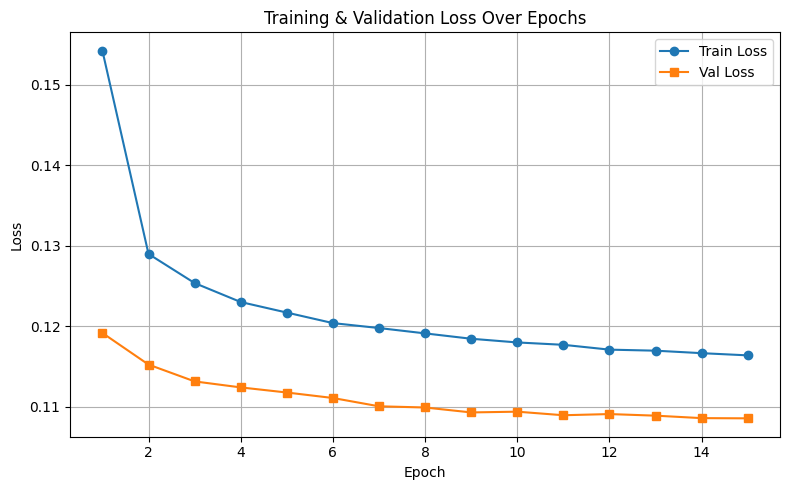

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from analysis.nn_model import EmbeddingClassifier

# Prepare feature matrix and labels
X_train = df_physionet_train.iloc[:, :ld].values  
X_test = df_physionet_test.iloc[:, :ld].values  
y_train = np.array(df_physionet_train['diagnostic'].tolist(), dtype=int)  
y_test = np.array(df_physionet_test['diagnostic'].tolist(), dtype=int)  

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # note: float for BCE loss
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Split into train and validation sets
val_ratio = 0.2
total_samples = X_train_tensor.size(0)
val_size = int(val_ratio * total_samples)
train_size = total_samples - val_size

train_dataset, val_dataset = random_split(
    TensorDataset(X_train_tensor, y_train_tensor),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Init model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = EmbeddingClassifier(input_dim=input_dim, output_dim=output_dim)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training loop
epochs = 15
train_losses = []
val_losses = []

print("🚀 Starting training...")
for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            output = model(xb)
            loss = criterion(output, yb)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    print(f"📉 Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Plot and save loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, marker='s', label='Val Loss')
plt.title("Training & Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("vae_train_val_loss.png")
print("📈 Saved training+validation loss plot as 'vae_train_val_loss.png'")


In [16]:
from sklearn.metrics import f1_score
import numpy as np

# Get probabilities from model
with torch.no_grad():
    logits = model(X_train_tensor)
    probs_val = torch.sigmoid(logits).cpu().numpy()

# Ground truth
y_train = y_train_tensor.cpu().numpy()

# Search for optimal thresholds (grid search over 0.0–1.0)
best_thresholds = []
for i in range(y_train.shape[1]):
    best_f1 = 0
    best_thresh = 0.5
    for t in np.linspace(0.1, 0.9, 17):  # test thresholds from 0.1 to 0.9
        preds = (probs_val[:, i] > t).astype(int)
        f1 = f1_score(y_train[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    best_thresholds.append(best_thresh)

best_thresholds = np.array(best_thresholds)


In [17]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Put model in evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits)
    # Make sure best_thresholds is a torch tensor, same shape as probs
    thresholds_tensor = torch.tensor(best_thresholds, dtype=torch.float32).to(probs.device)

    # Apply thresholds with broadcasting
    y_pred = (probs > thresholds_tensor).int().cpu().numpy()
# Convert ground truth to numpy (if it's still a tensor)
y_true = y_test_tensor.cpu().numpy()

# Compute metrics
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
overall_accuracy = accuracy_score(y_true, y_pred)

# Generate classification report (per label)
class_report = classification_report(
    y_true, y_pred,
    target_names=[str(i) for i in range(y_true.shape[1])],
    zero_division=0
)

# Print results
print("✅ Overall Accuracy:", overall_accuracy)
print("✅ F1 Score (Macro):", f1_macro)
print("✅ F1 Score (Micro):", f1_micro)
print("✅ Classification Report:\n", class_report)

✅ Overall Accuracy: 0.328271954674221
✅ F1 Score (Macro): 0.375977826571665
✅ F1 Score (Micro): 0.5749443732722002
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.70      0.50      1087
           1       0.50      0.81      0.62      1641
           2       0.11      0.23      0.15       106
           3       0.00      0.00      0.00        49
           4       0.77      0.67      0.71       323
           5       0.85      0.80      0.82       974
           6       0.39      0.50      0.44       715
           7       0.21      0.42      0.28       356
           8       0.51      0.72      0.60      1528
           9       0.49      0.57      0.53       459
          10       0.12      0.09      0.10        91
          11       0.00      0.00      0.00       336
          12       0.11      0.21      0.14       346
          13       0.10      0.10      0.10       334
          14       0.67      0.81      0.74     